### COSE362-02 Machine Learning&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Name: LE QUANG TRUNG&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Student ID: 2018320246

# Term Project: 
# Two Layer Neural Network Implementation and Spam/Ham Classification

## 1. Implementing 2 layers Neural Network

### Initial Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Network implementation

In [2]:
class NeuralNet(object):

    def __init__(self, in_size, hid_size, out_size):
        '''
        in_size: Dimension of input data
        hid_size: Number of hidden layer units
        out_size: number of classes(in this project is 2)
        '''
        std = 1e-4
        # Initialize to small random values
        self.W1 = std * np.random.randn(in_size, hid_size) #[D, H]
        self.W2 = std * np.random.randn(hid_size, out_size) #[H, C]
        # Initialize to zero
        self.b1 = np.zeros(hid_size) #[H,]
        self.b2 = np.zeros(out_size) #[C,]

    def loss(self, X, Y, reg): # Compute loss and gradients
        '''
        X: Input data(tranining examples)
        Y: Tranining examples labels
        reg: regularization strength
        '''
        W1 = self.W1
        b1 = self.b1
        W2 = self.W2
        b2 = self.b2
        N, D = X.shape # N: Number of traning samples, D: Dimention of input data

        # Forward propagation: compute loss
        # First layer:
        z1 = np.dot(X, W1) + b1 # [N, H]
        # ReLU:
        p1 = np.maximum(0, z1) # [N, H]
        # Second layer:
        z2 = np.dot(p1, W2) + b2 # [N, C]

        # Compute the loss: 
        # Data loss(Softmax Classifier = Softmax + Log likelihood loss):
        # Softmax
        unnormd_prob = np.exp(z2) #unnormalized probabilities matrix, shape = [N, C]
        C = len(unnormd_prob[0])
        p2 = np.copy(unnormd_prob)
        for i in range(N):
            p2[i, range(C)] = unnormd_prob[i, range(C)]/np.sum(unnormd_prob[i]) # [N, C]
        # Log likelihood loss
        data_loss = -(np.sum(np.log(p2[range(N), Y[range(N)]])))/N
        #L2 regularization loss(to W1 and W2))
        reg_loss = reg * np.sum(W1 ** 2) + reg * np.sum(W2 ** 2)
        #Loss = Data loss + Regularization loss
        loss = data_loss + reg_loss

        # Backward propagation: compute gradients
        #Backprop to Softmax
        dz2 = np.copy(p2) #shape: (N, C)
        dz2[range(N),Y[range(N)]] -=1 
        dz2 /= N
    
        dW2 = np.dot(p1.T, dz2) # [H, C]
        db2 = np.sum(dz2, axis = 0) # [C,]
        dp1 = np.dot(dz2, W2.T) # [N, H]
        dz1 = np.copy(dp1) # [N, H]
        #Backprop to ReLU
        dz1[z1 <= 0] = 0 # [N, H]
        dW1 = np.dot(X.T, dz1) # [D, H]
        db1 = np.sum(dz1, axis = 0) # [H,]
        #Gradients for L2 regularization term
        dW1_reg = 2 * reg * W1
        dW2_reg = 2 * reg * W2
    
        grads = {}
        grads['W1'] = dW1 + dW1_reg
        grads['W2'] = dW2 + dW2_reg
        grads['b1'] = db1
        grads['b2'] = db2

        return loss, grads

    def train(self, X, Y, X_test, Y_test, num_iters, learning_rate, learning_rate_decay,reg,
              batch_size, print_losses = False): #Train dataset
        '''
        X: Input data(tranining examples)
        Y: Tranining examples labels
        X_test: Testing examples
        Y_test: Testing examples labels
        num_iters: number of iterations
        learning_rate: learning rate
        learning_rate_decay: learning rate decay(used to decay LR after each epoch)
        batch_size: number of examples in a single batch
        print_losses: boolean used to print losses during training(default is False)
        '''
        # Use Mini-batch GD to optimize the parameters
        num_train = X.shape[0]
        losses = []
        train_accuracies = []
        test_accuracies = []
        
        # Create random minibatches of training data and labels
        for ite in range(num_iters):
            idx = np.random.choice(num_train, batch_size)
            X_batch = X[idx]
            Y_batch = Y[idx]
            
            # Compute loss and gradients using minibatch created above
            loss, grads = self.loss(X_batch, Y = Y_batch, reg = reg)
            
            # Update parameters
            self.W1 -= learning_rate * grads['W1']
            self.W2 -= learning_rate * grads['W2']
            self.b1 -= learning_rate * grads['b1']
            self.b2 -= learning_rate * grads['b2']

            #Check train and test accuracy and decay learning rate every epoch
            iters_per_epoch = int(num_train / batch_size)
            if ite % iters_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == Y_batch).mean()
                test_acc = (self.predict(X_test) == Y_test).mean()
                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)
                # Decay learning rate
                learning_rate *= learning_rate_decay
                
            losses.append(loss)
            # print loss every 100 iteration
            if print_losses:
                if ite % 100 == 0:
                    print('Iteration %d: loss = %f' % (ite, loss))

        return {
            'losses': losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
        }

    def predict(self, X): #Predict labels using trained weights
        #1st layer
        z1 = np.dot(X, self.W1) + self.b1
        #ReLU
        p1 = np.maximum(0, z1)
        #2nd layer
        z2 = np.dot(p1, self.W2) + self.b2
        #predicted labels
        Y_pred = np.argmax(z2, axis=1)

        return Y_pred

## 2. Spam/Ham Classification using 2-Layer Neural Network

### Loading data
The dataset consists of 8348 emails and their labels (0 for ham, 1 for spam).

It contains four columns:

1. `id`: An identifier for the training example
2. `subject`: The subject of the email
3. `email`: The text of the email
4. `spam`: 0 if the email is not spam and 1 if the email is spam

In [3]:
data = pd.read_csv('data/main_data.csv')
data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Check if data contains any missing values.
If there are NaN values, replace them with empty strings.

In [4]:
print('Before:')
print(data.isnull().sum())
data = data.fillna('')
print('\nAfter:')
print(data.isnull().sum())

Before:
id         0
subject    6
email      0
spam       0
dtype: int64

After:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training - Testing Split
Split the training data into separate training and testing datasets. Set the `seed (random_state)` to 2022 to make the random predictable.

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size= 0.1, random_state = 2022)

print(train.shape, test.shape)

(7513, 4) (835, 4)


In [6]:
train = train.reset_index(drop = True) 
train.head()

,id,subject,email,spam
0,5551,Subject: Free Step-By-Step Seminar Presentation\n,This is a multi-part message in MIME format.\n...,1
1,4285,Subject: Proven way to get a job....\n,\n \n ------ack1234\n Content-Type: multipart/...,1
2,7781,Subject: IMF shores up debt defences\n,"URL: http://www.newsisfree.com/click/-1,838114...",0
3,5027,Subject: Market Can't Find Its Bottom With Bot...,This is a multi-part message in MIME format......,0
4,6107,"Subject: dave,Hi,, extra Low price inkjet cart...",go.. jm@netnoteinc.com\n <html>\n <head>\n <t...,1


### Covert set of email texts to a frequency distribution matrix
Transform **email** column using sklearn's CountVectorizer. CountVectorizer will calculate an individual word count in **email** column.

We use two parameters :
1. `max_features`: limits the number of distinct individual tokens/words.
2. `stop_words` = english: eliminates the common English words.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(max_features = 1000, stop_words = 'english')

**Fit and transform the training data**

In [8]:
X_train = count_vector.fit_transform(train['email']).toarray()
Y_train = train['spam'].values

frequency_matrix_train = pd.DataFrame(X_train, columns = count_vector.get_feature_names_out())
frequency_matrix_train

,00,000,000000,000066,000080,0000ff,01,02,03,04,...,www,xent,xml,xp,yahoo,year,years,yes,york,zdnet
0,0,0,2,4,1,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,3,0,0,...,7,0,0,0,0,0,2,0,0,0
2,2,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9,0,28,0,0,0,12,0,0,0,...,96,0,0,0,9,0,6,2,10,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,1,3,3,0,0,2,0,1,0,0,...,87,0,4,2,0,4,0,0,1,0
7509,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7510,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7511,1,11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


**Transform the test data to observe document term matrix.**

In [9]:
X_test = count_vector.transform(test['email']).toarray()
Y_test = test['spam'].values

frequency_matrix_test = pd.DataFrame(X_test, columns = count_vector.get_feature_names_out())
frequency_matrix_test

,00,000,000000,000066,000080,0000ff,01,02,03,04,...,www,xent,xml,xp,yahoo,year,years,yes,york,zdnet
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0,0,0,0,0,0,0,0,1,0,...,2,0,0,0,0,0,0,0,0,0
831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
832,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,7,0
833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0


### Train the network

**Check the shape of training and testing datasets**

In [10]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Train data shape:  (7513, 1000)
Train labels shape:  (7513,)
Test data shape:  (835, 1000)
Test labels shape:  (835,)


**Firstly, training the network with hidden size of 50, iteration number of 1000, batch size of 200, learning rate of 0.01, learning rate decay of 0.95, regularization of 0.001.** **Setting** `print_losses = True` **will print losses each 100 iterations.**

In [11]:
input_size = 1000
hidden_size = 50
num_classes = 2
net = NeuralNet(input_size, hidden_size, num_classes)
# Train
stats = net.train(X_train, Y_train, X_test, Y_test, num_iters = 1000, batch_size = 200,learning_rate = 0.01,
                  learning_rate_decay=0.95, reg = 0.001, print_losses = True)

# Predict
train_acc = (net.predict(X_train) == Y_train).mean()
print('Training accuracy: ', train_acc)
test_acc = (net.predict(X_test) == Y_test).mean()
print('Testing accuracy: ', test_acc)

Iteration 0: loss = 0.693148
Iteration 100: loss = 0.616861
Iteration 200: loss = 0.505316
Iteration 300: loss = 0.486834
Iteration 400: loss = 0.339835
Iteration 500: loss = 0.324309
Iteration 600: loss = 0.261574
Iteration 700: loss = 0.281771
Iteration 800: loss = 0.276629
Iteration 900: loss = 0.230777
Training accuracy:  0.8965792626114735
Testing accuracy:  0.881437125748503


**Plot *Loss history* and *Accuracy history* graph**

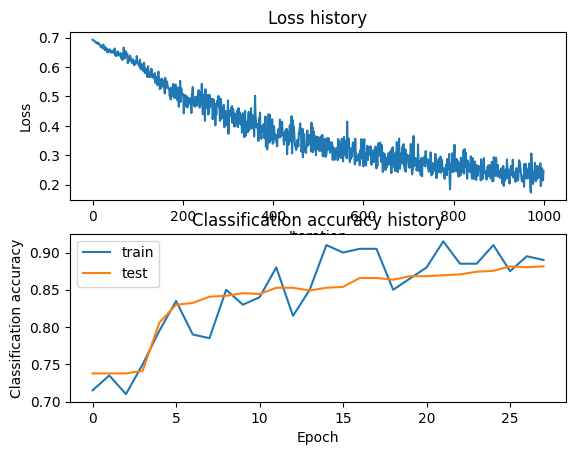

In [12]:
plt.subplot(2, 1, 1)
plt.plot(stats['losses'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_accuracies'], label='train')
plt.plot(stats['test_accuracies'], label='test')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

### Hyperparameters optimization

In [13]:
learning_rates = []
regs = []
hidden_sizes = []
best_train_acc = 0
best_hidden_size = None
best_reg = None
best_learning_rate = None
best_net = None 

input_size = 1000
num_classes = 2

np.random.seed(2022)
#Create learning rates, regularization strengths and hidden sizes randomly
for i in range(20):
    lr= 10 ** np.random.uniform(-2, -1)
    reg_strength = 10 ** np.random.uniform(-3, -2)
    hsize = 10 * np.random.randint(5,11)

    net = NeuralNet(input_size, hsize, num_classes)
            
    stats = net.train(X_train, Y_train, X_test, Y_test, num_iters= 1000, batch_size= 200, learning_rate= lr,
                      learning_rate_decay = 0.95, reg = reg_strength, print_losses = False)
    
    train_acc = (net.predict(X_train) == Y_train).mean()
    print('Training accuracy for hidden size %d, learning rate %e and reg %e: %.3f' % (hsize, lr, reg_strength, train_acc))
    
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_hidden_size = hsize
        best_reg = reg_strength
        best_learning_rate = lr
        best_net = net
    
print('Best training accuracy: %.3f (with hidden size = %d, learning rate = %e and reg = %e' % (best_train_acc ,best_hidden_size, best_learning_rate, best_reg))

Training accuracy for hidden size 60, learning rate 1.021783e-02 and reg 3.155425e-03: 0.901
Training accuracy for hidden size 90, learning rate 1.223611e-02 and reg 3.294453e-03: 0.927
Training accuracy for hidden size 100, learning rate 4.469299e-02 and reg 3.438584e-03: 0.984
Training accuracy for hidden size 90, learning rate 5.464343e-02 and reg 9.535546e-03: 0.983
Training accuracy for hidden size 70, learning rate 7.060471e-02 and reg 3.952740e-03: 0.987
Training accuracy for hidden size 100, learning rate 6.247042e-02 and reg 3.366092e-03: 0.988
Training accuracy for hidden size 80, learning rate 2.668219e-02 and reg 1.172129e-03: 0.965
Training accuracy for hidden size 90, learning rate 1.234203e-02 and reg 2.022898e-03: 0.926
Training accuracy for hidden size 60, learning rate 1.179254e-02 and reg 3.495100e-03: 0.919
Training accuracy for hidden size 80, learning rate 5.619413e-02 and reg 3.751045e-03: 0.985
Training accuracy for hidden size 80, learning rate 2.742439e-02 and

**Train the network one more time using** `best_net` **with tuned hyperparameters**

In [14]:
final_stats = best_net.train(X_train, Y_train, X_test, Y_test, num_iters = 1000, batch_size = 200,
                             learning_rate = best_learning_rate, learning_rate_decay = 0.95,
                             reg = best_reg, print_losses = False)

# Predict
train_acc = (best_net.predict(X_train) == Y_train).mean()
print('Training accuracy: ', train_acc)
test_acc = (best_net.predict(X_test) == Y_test).mean()
print('Testing accuracy: ', test_acc)

Training accuracy:  0.9944096898708905
Testing accuracy:  0.9832335329341317


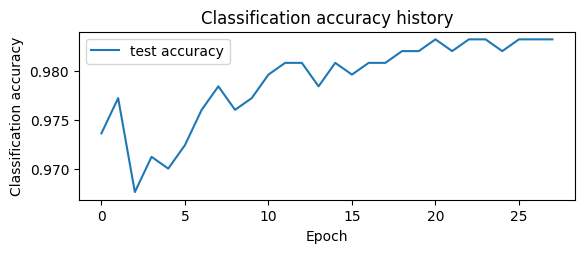

In [15]:
plt.subplot(2, 1, 2)
plt.plot(final_stats['test_accuracies'], label='test accuracy')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## Compare to the result using Sklearn LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, Y_train)
training_accuracy = model.score(X_train, Y_train)
test_accuracy = model.score(X_test, Y_test)

print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", test_accuracy)

Training Accuracy:  0.9988020764009051
Testing Accuracy:  0.9820359281437125
